In [1]:
## personal imports
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from datetime import datetime
from fund.fund import Fund
from pricer.pricer import Pricer as pricer_list
from ranker.ranker import Ranker as ranker_list
from classifier.classifier import Classifier as classifier_list
from portfolio.aportfolio import APortfolio

## analysis imports
from analysis.quarterly_analysis import QuarterlyAnalysis as quarterly_analysis
from analysis.weekly_analysis import WeeklyAnalysis as weekly_analysis

## risk and return class imports
from returns.products import Products as returns_products_class
from fund.fund import Fund

## standard imports
from statistics import variance
import math
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
backtest_start_date = datetime(2001,1,1)
backtest_end_date  = datetime(2023,1,1)
current_start_date = datetime(2023,1,1)

In [3]:
market = Market()

In [54]:
# portfolio = APortfolio(pricer_list.WEEKLY_STOCK_SPECULATION
#                           ,classifier_list.NONE
#                           ,ranker_list.NONE)
# portfolio_ii = APortfolio(pricer_list.WEEKLY_STOCK_ROLLING
#                            ,classifier_list.NONE
#                           ,ranker_list.NONE)
# portfolio_iii = APortfolio(pricer_list.WEEKLY_STOCK_WINDOW
#                           ,classifier_list.NONE
#                           ,ranker_list.NONE)
portfolio_iv = APortfolio(pricer_list.WEEKLY_CRYPTO_ROLLING
                          ,classifier_list.NONE
                          ,ranker_list.NONE)
portfolio_v = APortfolio(pricer_list.WEEKLY_CRYPTO_WINDOW
                          ,classifier_list.NONE
                          ,ranker_list.NONE)
portfolio_vi = APortfolio(pricer_list.WEEKLY_CRYPTO_SPECULATION
                          ,classifier_list.NONE
                          ,ranker_list.NONE)

portfolios = []
# portfolios.append(portfolio)
# portfolios.append(portfolio_ii)
# portfolios.append(portfolio_iii)
portfolios.append(portfolio_iv)
portfolios.append(portfolio_v)
portfolios.append(portfolio_vi)

In [55]:
fund = Fund(portfolios,backtest_start_date,backtest_end_date,current_start_date)
market = Market()
fund.initialize_portfolios()

In [56]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()
sp500 = sp500.rename(columns={"Symbol":"ticker"})

In [57]:
market.connect()
tyields = returns_products_class.tyields(market.retrieve("tyields"))
bench_returns = returns_products_class.spy_bench(market.retrieve("spy"))
market.disconnect()

In [58]:
trades = []
for portfolio in fund.portfolios:
    portfolio.db.connect()
    trade = portfolio.db.retrieve("trades")
    trade["positions"] = int(portfolio.pricer_class.positions)
    trade["portfolio"] = portfolio.name
    trade["pricer_timeframe"] = portfolio.pricer_class.time_horizon_class.naming_convention
    trades.append(trade)
    portfolio.db.disconnect()

In [59]:
t = pd.concat(trades)
t = t[(t["year"]>=backtest_start_date.year) & (t["year"]<backtest_end_date.year)]

In [60]:
nonindex_columns = [
"year"
,"quarter"
,"week"
,"ticker"
,"quarterly_delta_sign"
,"quarterly_delta"
,"weekly_delta_sign"
,"weekly_delta"
,"short_returns"
,"returns"
,"floored_returns"
,"actual_returns"
,"position"
,"projected_quarterly_return"
,"positions"] 

In [61]:
indexers = []
indexer = []
for col in t.columns:
    if col not in nonindex_columns:
        indexers.append(list(t[col].unique()))
        indexer.append(col)
stuff = t[indexer].to_dict("records")
parameters = [dict(t) for t in {tuple(d.items()) for d in stuff}]

In [62]:
indexer

['value',
 'ceiling',
 'classification',
 'rank',
 'short',
 'market_return',
 'buy_day',
 'sell_day',
 'risk',
 'floor_value',
 'portfolio',
 'pricer_timeframe']

In [63]:
analysis = []
for parameter in tqdm(parameters):
    try:
        ledger = t.sort_values(["year",parameter["pricer_timeframe"]]).copy()
        for key in parameter.keys():
            ledger = ledger[ledger[key]==parameter[key]]
        positions = int(int(ledger["positions"].mean()))
        anas = weekly_analysis if parameter["pricer_timeframe"] == "week" else quarterly_analysis
        if ledger.index.size > 0:
            cumulative = anas.trade_analysis(indexer,ledger,positions,parameter,tyields,bench_returns)
            analysis.append(cumulative[indexer + ["pv","beta","rrr","sharpe"]].iloc[-1])
    except Exception as e:
        print(str(e))
        continue
a = pd.DataFrame(analysis)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:02<00:00, 41.86it/s]


In [64]:
a.sort_values("pv",ascending=False).head(20)

,value,ceiling,classification,rank,short,market_return,buy_day,sell_day,risk,floor_value,portfolio,pricer_timeframe,pv,beta,rrr,sharpe
58,True,True,False,False,False,1.15,1,20,False,0.50,wcr_n_n_b_r,week,2.736067,-0.560603,0.768684,-3.096166
59,True,True,False,False,False,1.15,1,20,False,1.00,wcr_n_n_b_r,week,2.672669,-0.555838,0.771660,-3.008648
25,True,True,False,False,False,1.15,1,20,True,0.50,wcr_n_n_b_r,week,2.462478,-0.883017,0.715874,-1.655834
142,True,True,False,False,False,1.15,1,5,True,0.50,wcr_n_n_b_r,week,2.420479,-0.038448,0.987087,-36.936190
26,True,True,False,False,False,1.15,1,20,True,1.00,wcr_n_n_b_r,week,2.405419,-0.875738,0.718790,-1.604444
144,True,True,False,False,False,1.15,1,5,True,1.00,wcr_n_n_b_r,week,2.402926,-0.040464,0.986432,-34.662748
111,True,True,False,False,False,1.15,1,10,False,1.00,wcr_n_n_b_r,week,2.247738,-0.288624,0.881595,-4.321854
109,True,True,False,False,False,1.15,1,10,False,0.50,wcr_n_n_b_r,week,2.129865,-0.294741,0.878445,-3.832241
83,True,True,False,False,False,1.15,1,10,True,1.00,wcr_n_n_b_r,week,2.081468,-0.349250,0.870062,-3.095554
37,True,True,False,False,False,1.15,1,20,True,0.50,wcw_n_n_b_r,week,2.080798,0.286832,1.130839,3.766840


In [65]:
a.sort_values("pv",ascending=False).groupby("portfolio").nth(0).reset_index()

,portfolio,value,ceiling,classification,rank,short,market_return,buy_day,sell_day,risk,floor_value,pricer_timeframe,pv,beta,rrr,sharpe
0,wcr_n_n_b_r,True,True,False,False,False,1.15,1,20,False,0.5,week,2.736067,-0.560603,0.768684,-3.096166
1,wcs_n_n_b_r,True,True,False,False,False,1.15,1,5,False,0.5,week,1.304197,0.045813,1.006342,6.632416
2,wcw_n_n_b_r,True,True,False,False,False,1.15,1,20,True,0.5,week,2.080798,0.286832,1.130839,3.766840


In [66]:
top = a.sort_values("pv",ascending=False).iloc[0]
anas = weekly_analysis if top["pricer_timeframe"] == "week" else quarterly_analysis
analysis = t
for key in parameter.keys():
    analysis = analysis[(analysis[key]==top[key])]
naming = top["pricer_timeframe"]
ledger = analysis[["year",naming,"ticker",f"{naming}ly_delta",f"{naming}ly_delta_sign","actual_returns","position"]]
ledger = ledger[ledger["year"]>=backtest_start_date.year]
ledger = ledger.merge(sp500[["ticker","GICS Sector","Security"]],on="ticker",how="left")

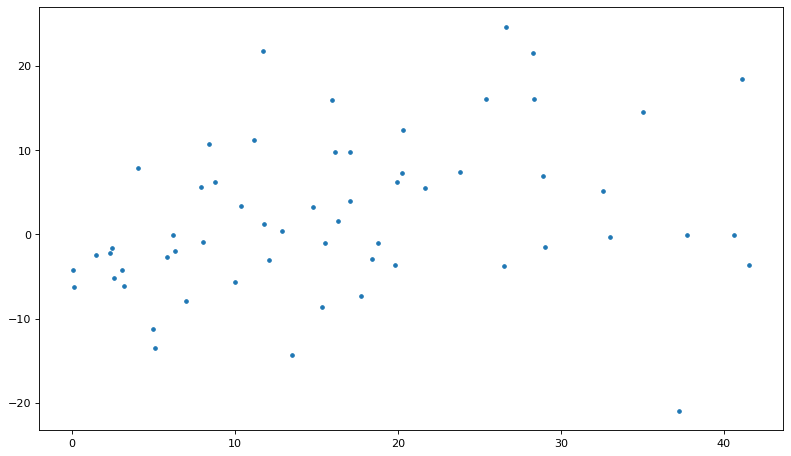

In [67]:
plt.figure(figsize=(12, 7), dpi=80)
plt.scatter(ledger[f"{naming}ly_delta"] * 100, (ledger["actual_returns"]-1)*100,s=10)

In [68]:
ledger.sort_values(["year",naming,"position"],ascending=True).head(20)

,year,week,ticker,weekly_delta,weekly_delta_sign,actual_returns,position,GICS Sector,Security
0,2015,12,BTC,0.070175,1.0,0.921423,0,NaN,NaN
1,2015,28,BTC,0.111433,1.0,1.112199,0,NaN,NaN
2,2015,32,BTC,0.099952,1.0,0.943444,0,NaN,NaN
3,2015,44,BTC,0.117468,1.0,1.217962,0,NaN,NaN
4,2015,48,BTC,0.159825,1.0,1.159165,0,NaN,NaN
5,2015,52,BTC,0.264947,1.0,0.962312,0,NaN,NaN
6,2016,4,BTC,0.025874,1.0,0.948333,0,NaN,NaN
7,2016,8,BTC,0.080242,1.0,0.990364,0,NaN,NaN
8,2016,16,BTC,0.040263,1.0,1.078059,0,NaN,NaN
9,2016,20,BTC,0.058134,1.0,0.972673,0,NaN,NaN


In [69]:
ledger["actual_returns"].mean()

1.0213239015766693

In [70]:
ledger[ledger["actual_returns"]>1].index.size / ledger.index.size

0.4745762711864407

In [71]:
portfolio = ledger.pivot_table(index=["year",naming],columns="position",values="actual_returns").fillna(1).reset_index()

In [72]:
portfolio

position,year,week,0
0,2015,12,0.921423
1,2015,28,1.112199
2,2015,32,0.943444
3,2015,44,1.217962
4,2015,48,1.159165
5,2015,52,0.962312
6,2016,4,0.948333
7,2016,8,0.990364
8,2016,16,1.078059
9,2016,20,0.972673


In [73]:
cumulative = anas.iteration_analysis(portfolio,positions,bench_returns)

In [74]:
cumulative.head(50)

,0,year,week,pv,adjclose,bench,date_string,date
0,0.921423,2015,12,0.921423,2056.64,1.000000,2015-W12,2015-03-20
1,1.024806,2015,28,1.024806,2068.74,1.005883,2015-W28,2015-07-10
2,0.966847,2015,32,0.966847,2096.39,1.019328,2015-W32,2015-08-07
3,1.177583,2015,44,1.177583,2042.21,0.992984,2015-W44,2015-10-30
4,1.365013,2015,48,1.365013,2071.52,1.007235,2015-W48,2015-11-27
5,1.313568,2015,52,1.313568,2037.17,0.990533,2015-W52,2015-12-25
6,1.245700,2016,4,1.245700,1879.14,0.913694,2016-W4,2016-01-29
7,1.233696,2016,8,1.233696,1914.50,0.930887,2016-W8,2016-02-26
8,1.329997,2016,16,1.329997,2069.93,1.006462,2016-W16,2016-04-22
9,1.293651,2016,20,1.293651,2063.65,1.003408,2016-W20,2016-05-20


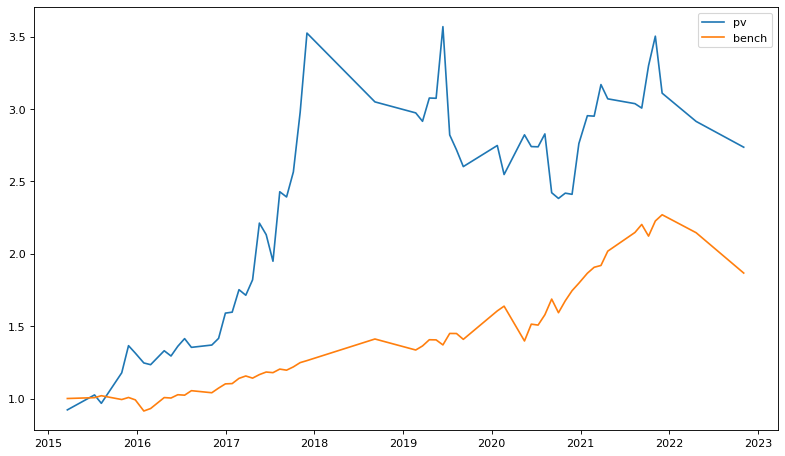

In [75]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])

In [76]:
cumulative.tail(20)

,0,year,week,pv,adjclose,bench,date_string,date
39,2.821644,2020,20,2.821644,2874.12,1.397483,2020-W20,2020-05-15
40,2.740438,2020,24,2.740438,3113.14,1.513702,2020-W24,2020-06-12
41,2.738781,2020,28,2.738781,3099.85,1.507240,2020-W28,2020-07-10
42,2.827893,2020,32,2.827893,3246.73,1.578657,2020-W32,2020-08-07
43,2.421639,2020,36,2.421639,3469.24,1.686848,2020-W36,2020-09-04
44,2.382280,2020,40,2.382280,3275.72,1.592753,2020-W40,2020-10-02
45,2.418624,2020,44,2.418624,3444.90,1.675014,2020-W44,2020-10-30
46,2.410625,2020,48,2.410625,3588.73,1.744948,2020-W48,2020-11-27
47,2.761091,2020,52,2.761091,3695.03,1.796634,2020-W52,2020-12-25
48,2.953616,2021,4,2.953616,3836.33,1.865339,2021-W4,2021-01-29


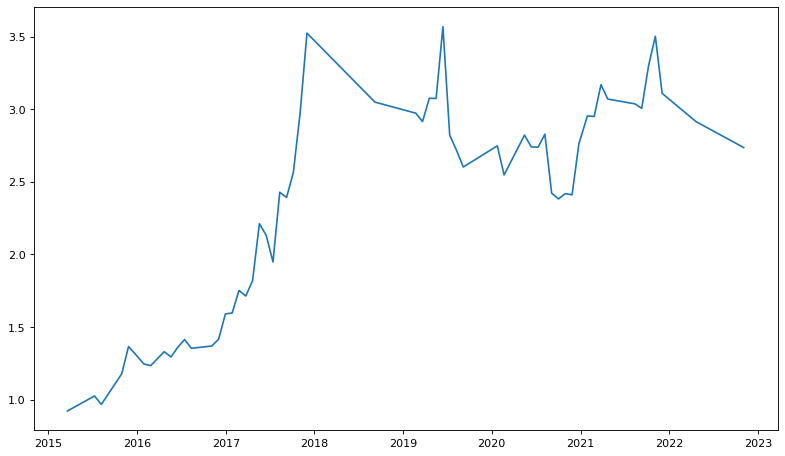

In [77]:
plt.figure(figsize=(12, 7), dpi=80)
position_columns = [x for x in cumulative.columns if x not in ["year","week","quarter","date_string","date","pv","adjclose","bench"]]
for i in position_columns:
    position = cumulative[i]
    plt.plot(cumulative["date"],position)

plt.show()


In [78]:
ledger.groupby(["GICS Sector"]).mean().sort_values("actual_returns",ascending=False)

,year,week,weekly_delta,weekly_delta_sign,actual_returns,position
GICS Sector,,,,,,


In [79]:
ledger.groupby(["year",naming,"ticker","Security"]).prod().sort_values("actual_returns",ascending=False).head(30)

,,,,weekly_delta,weekly_delta_sign,actual_returns,position
year,week,ticker,Security,,,,


In [80]:
industry_analysis = ledger.pivot_table(index=["year",naming],columns="GICS Sector",values="actual_returns").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x != "sell_date"]].cumprod()

GICS Sector,year,week
